### Sentiment Analysis


In [2]:
!pip install textblob
import pandas as pd
import numpy as np
import re 
from textblob import TextBlob 
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [4]:
#Import the CEO tweets file
ceo_tweets=pd.read_csv('data/ceo_tweets_final.csv')
print(ceo_tweets[:5])
print(len(ceo_tweets))


   Unnamed: 0   username                   id                 date  \
0           0  @tim_cook  1200060640469159939  2019-11-28 14:35:27   
1           1  @tim_cook  1200047686180835328  2019-11-28 13:43:58   
2           2  @tim_cook  1199872990718169089  2019-11-28 02:09:48   
3           3  @tim_cook  1199855397617704970  2019-11-28 00:59:53   
4           4  @tim_cook  1199767313890922497  2019-11-27 19:09:52   

                                               tweet  retweets  likes  
0  On this #Thanksgiving, I am reflecting on the ...       546   4434  
1  Wishing everyone a #HappyThanksgiving filled w...       575   6097  
2  Tomorrow the incredible @MNightShyamalan’s ser...       412   2607  
3  Thanksgiving Day challenge! Close your rings w...       394   3932  
4  As many of you travel to be with loved ones to...      1310   8436  
60947


In [5]:
#Data Manipulation
ceo_tweets["date"] = pd.to_datetime(ceo_tweets['date'])
ceo_tweets = ceo_tweets[ceo_tweets['date'].dt.year>2016]
ceo_tweets["date"]=ceo_tweets["date"].apply(lambda x: x.date())

In [6]:
# Number of tweets for each CEO
ceo_tweets.groupby(['username'])['tweet'].count()

username
@Benioff            3230
@BillGates           983
@Bill_Gross         1463
@BoeingCEO           450
@ChuckRobbins        996
@IndraNooyi          147
@JeffBezos           150
@JohnLegere         3236
@LisaSu              172
@MichaelDell        1020
@WaltBettinger       449
@anandmahindra      3221
@aneelb              100
@bchesky             650
@drewhouston          75
@eldsjal             486
@elonmusk           3247
@jack               3225
@levie               538
@lloydblankfein       68
@marissamayer         78
@mtbarra             212
@richardbranson     3221
@rupertmurdoch         1
@satyanadella        501
@sundarpichai        432
@tim_cook            610
@toddmckinnon        181
@tonyfernandes      3196
@westernunionCEO     916
Name: tweet, dtype: int64

In [7]:
# Clean the tweets

def clean_tweet(tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()) #(@[A-Za-z0-9]+)|

<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\w'
/var/folders/vs/psr5cjxj5_g37zw1047vgdx80000gn/T/ipykernel_2313/2485286117.py:8: SyntaxWarning: invalid escape sequence '\w'
  return ' '.join(re.sub("([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", tweet).split()) #(@[A-Za-z0-9]+)|


In [8]:
#Remove special characters and lower case the tweets
ceo_tweets['clean_tweets']=ceo_tweets['tweet'].map(clean_tweet)
ceo_tweets['tweet']=ceo_tweets['tweet'].map(str.lower)
ceo_tweets[:5]


,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...


In [9]:
# Sentiment Analysis functions:

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        return analysis.sentiment.polarity
        
def sentiment_buckets(score):
        ''' 
        Utility function to classify the sentiment bucket 
        '''
        # set sentiment : 5% offset
        if score > 0.05: 
            return 'positive'
        elif score < -0.05: 
            return 'negative'
        else: 
            return 'neutral'

In [10]:
# create sentiment score and sentiment bucket columns
ceo_tweets['sentiment_score']=ceo_tweets['clean_tweets'].map(get_tweet_sentiment)
ceo_tweets['sentiment_bucket']=ceo_tweets['sentiment_score'].map(sentiment_buckets)
ceo_tweets[:5]


,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket
0,0,@tim_cook,1200060640469159939,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive
1,1,@tim_cook,1200047686180835328,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive
2,2,@tim_cook,1199872990718169089,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...,0.900000,positive
3,3,@tim_cook,1199855397617704970,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...,0.000000,neutral
4,4,@tim_cook,1199767313890922497,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive


### Sentiment EDA:

Matplotlib is building the font cache; this may take a moment.


<Axes: >

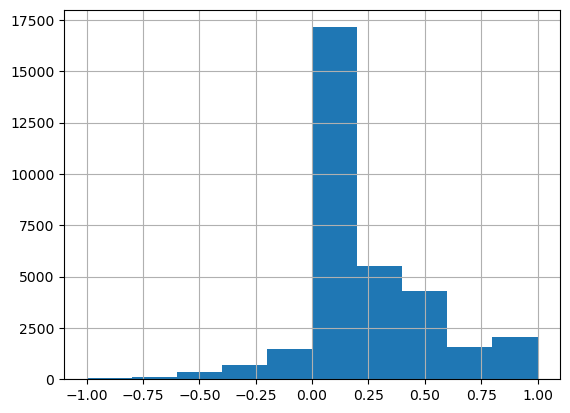

In [11]:
# sentiment EDA :
# Sentiment score distrution
ceo_tweets['sentiment_score'].hist()

In [12]:
# CEO level sentiment EDA:
# sentiment score statistics 
ceo_tweets.groupby('username')['sentiment_score'].agg(['min','max','mean','median'])

,min,max,mean,median
username,,,,
@Benioff,-1.000000,1.0,0.178951,0.100000
@BillGates,-1.000000,1.0,0.221416,0.200000
@Bill_Gross,-1.000000,1.0,0.190096,0.150000
@BoeingCEO,-0.500000,1.0,0.288584,0.250000
@ChuckRobbins,-1.000000,1.0,0.384362,0.400000
@IndraNooyi,-0.800000,1.0,0.270405,0.250000
@JeffBezos,-0.250000,1.0,0.253642,0.201389
@JohnLegere,-1.000000,1.0,0.190867,0.000000
@LisaSu,0.000000,1.0,0.442633,0.430000


In [13]:
# sentiment score table to calculate % distrbution for sentiment buckets
df_sent_bucket=pd.DataFrame(ceo_tweets.groupby(['username','sentiment_bucket'])['sentiment_score'].agg('count'))
df_sent_bucket=df_sent_bucket.reset_index()
df_sent_bucket.columns=['username','sentiment_bucket','tweet_cnt']
df_sent_bucket[:5]

,username,sentiment_bucket,tweet_cnt
0,@Benioff,negative,253
1,@Benioff,neutral,1258
2,@Benioff,positive,1719
3,@BillGates,negative,96
4,@BillGates,neutral,255


In [14]:
#pivot the results
df_sent_pivot= pd.pivot_table(df_sent_bucket,index=["username"],columns=["sentiment_bucket"]).fillna(0)
df_sent_pivot['perc_negative']=df_sent_pivot['tweet_cnt']['negative']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot['perc_positive']=df_sent_pivot['tweet_cnt']['positive']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot['perc_neutral']=df_sent_pivot['tweet_cnt']['neutral']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot

tweet_cnt                  perc_negative perc_positive  \
sentiment_bucket  negative neutral positive                               
username                                                                  
@Benioff             253.0  1258.0   1719.0      7.832817     53.219814   
@BillGates            96.0   255.0    632.0      9.766022     64.292981   
@Bill_Gross          143.0   455.0    865.0      9.774436     59.125085   
@BoeingCEO            10.0   101.0    339.0      2.222222     75.333333   
@ChuckRobbins         38.0   215.0    743.0      3.815261     74.598394   
@IndraNooyi            7.0    41.0     99.0      4.761905     67.346939   
@JeffBezos             6.0    50.0     94.0      4.000000     62.666667   
@JohnLegere          146.0  1831.0   1259.0      4.511743     38.906057   
@LisaSu                0.0     9.0    163.0      0.000000     94.767442   
@MichaelDell          18.0   315.0    687.0      1.764706     67.352941   
@WaltBettinger        30.0   104.0    315.0      6.681514     70.155902   
@anandmahindra       241.0  1332.0   1648.0      7.482148     51.164235   
@aneelb                5.0    28.0     67.0      5.000000     67.000000   
@bchesky              58.0   254.0    338.0      8.923077     52.000000   
@drewhouston           3.0    30.0     42.0      4.000000     56.000000   
@eldsjal              41.0   193.0    252.0      8.436214     51.851852   
@elonmusk            299.0  1625.0   1323.0      9.208500     40.745303   
@jack                179.0  1857.0   1189.0      5.550388     36.868217   
@levie                65.0   209.0    264.0     12.081784     49.070632   
@lloydblankfein       11.0    21.0     36.0     16.176471     52.941176   
@marissamayer          5.0    37.0     36.0      6.410256     46.153846   
@mtbarra               7.0    72.0    133.0      3.301887     62.735849   
@richardbranson      226.0   865.0   2130.0      7.016455     66.128532   
@rupertmurdoch         0.0     1.0      0.0      0.000000      0.000000   
@satyanadella         30.0   170.0    301.0      5.988024     60.079840   
@sundarpichai         27.0   113.0    292.0      6.250000     67.592593   
@tim_cook             29.0   162.0    419.0      4.754098     68.688525   
@toddmckinnon         12.0    77.0     92.0      6.629834     50.828729   
@tonyfernandes       277.0  1172.0   1747.0      8.667084     54.662078   
@westernunionCEO      40.0   412.0    464.0      4.366812     50.655022   

                 perc_neutral  
sentiment_bucket               
username                       
@Benioff            38.947368  
@BillGates          25.940997  
@Bill_Gross         31.100478  
@BoeingCEO          22.444444  
@ChuckRobbins       21.586345  
@IndraNooyi         27.891156  
@JeffBezos          33.333333  
@JohnLegere         56.582200  
@LisaSu              5.232558  
@MichaelDell        30.882353  
@WaltBettinger      23.162584  
@anandmahindra      41.353617  
@aneelb             28.000000  
@bchesky            39.076923  
@drewhouston        40.000000  
@eldsjal            39.711934  
@elonmusk           50.046196  
@jack               57.581395  
@levie              38.847584  
@lloydblankfein     30.882353  
@marissamayer       47.435897  
@mtbarra            33.962264  
@richardbranson     26.855014  
@rupertmurdoch     100.000000  
@satyanadella       33.932136  
@sundarpichai       26.157407  
@tim_cook           26.557377  
@toddmckinnon       42.541436  
@tonyfernandes      36.670839  
@westernunionCEO    44.978166

In [15]:
# Levie analysis
ceo_tweets[(ceo_tweets['username']=='@lloydblankfein') & (ceo_tweets['sentiment_score']<-0.05 )][['tweet','username','sentiment_score']].sort_values(by='sentiment_score',ascending = True)

# Levie - even though the overall sentiment score is negative, the actual topics he tweets about are optimistic and appreciative (proved from topic modeling)

,tweet,username,sentiment_score
34906,still thinking about #bitcoin. no conclusion -...,@lloydblankfein,-0.500000
34877,the house not focusing on anti-semitism but in...,@lloydblankfein,-0.483333
34922,leadership helps 🇺🇸our language is dominant; $...,@lloydblankfein,-0.350000
34878,"after killing amazon's nyc hq, not sure some p...",@lloydblankfein,-0.250000
34867,uh-oh. can another round of tariffs be far beh...,@lloydblankfein,-0.166667
34866,don't know why sen. sanders picks on a retiree...,@lloydblankfein,-0.155556
34914,"every now and then, david lets his hair down.....",@lloydblankfein,-0.155556
34919,congrats to @jeffimmelt for leading ge thru 9/...,@lloydblankfein,-0.150000
34909,immigration is a complex issue but i wouldn't ...,@lloydblankfein,-0.150000
34917,rt @goldmansachs: $gs ceo @lloydblankfein on t...,@lloydblankfein,-0.100000


### Bag of words analysis

In [16]:
# import the necessary libraries

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

In [17]:
## Removing stop words, punctuation and tokenizing

import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')

ceo_tweets["clean_tweets"] = ceo_tweets["clean_tweets"].astype(str)
ceo_tweets["tweet_tokens"] = ceo_tweets["clean_tweets"].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
ceo_tweets["tweet_tokens"] = ceo_tweets["tweet_tokens"].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])

ceo_tweets[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/snehabhaskara/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/snehabhaskara/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/snehabhaskara/nltk_data'
    - '/opt/miniconda3/envs/dso576/nltk_data'
    - '/opt/miniconda3/envs/dso576/share/nltk_data'
    - '/opt/miniconda3/envs/dso576/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [189]:
#Obtain POS for the tokens
#import nltk
nltk.download('averaged_perceptron_tagger')
ceo_tweets['pos']=ceo_tweets['tweet_tokens'].apply(nltk.tag.pos_tag)
ceo_tweets[:5]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aishw\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,tweet_tokens,pos
0,0,@tim_cook,1.200060e+18,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive,"[thanksgiving, reflecting, dreamers, enjoy, da...","[(thanksgiving, VBG), (reflecting, VBG), (drea..."
1,1,@tim_cook,1.200050e+18,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive,"[wishing, everyone, happythanksgiving, filled,...","[(wishing, VBG), (everyone, NN), (happythanksg..."
2,2,@tim_cook,1.199870e+18,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...,0.900000,positive,"[tomorrow, incredible, mnightshyamalan, series...","[(tomorrow, NN), (incredible, JJ), (mnightshya..."
3,3,@tim_cook,1.199860e+18,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...,0.000000,neutral,"[thanksgiving, day, challenge, close, rings, f...","[(thanksgiving, VBG), (day, NN), (challenge, V..."
4,4,@tim_cook,1.199770e+18,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive,"[many, travel, loved, ones, today, remember, p...","[(many, JJ), (travel, NN), (loved, VBD), (ones..."


In [190]:
# Extract the list of nouns to create manual buckets based on them:
ceo_tweets['nouns']=ceo_tweets['pos'].apply(lambda pos_list: [x[0] for x in pos_list if x[1].startswith('NN')])
ceo_tweets[:5]

,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,tweet_tokens,pos,nouns
0,0,@tim_cook,1.200060e+18,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive,"[thanksgiving, reflecting, dreamers, enjoy, da...","[(thanksgiving, VBG), (reflecting, VBG), (drea...","[dreamers, day, friends, family]"
1,1,@tim_cook,1.200050e+18,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive,"[wishing, everyone, happythanksgiving, filled,...","[(wishing, VBG), (everyone, NN), (happythanksg...","[everyone, joy, amp, happiness, today, thankf]"
2,2,@tim_cook,1.199870e+18,2019-11-28,tomorrow the incredible @mnightshyamalan’s ser...,412,2607,Tomorrow the incredible @MNightShyamalan’s ser...,0.900000,positive,"[tomorrow, incredible, mnightshyamalan, series...","[(tomorrow, NN), (incredible, JJ), (mnightshya...","[tomorrow, mnightshyamalan, series, servant, a..."
3,3,@tim_cook,1.199860e+18,2019-11-28,thanksgiving day challenge! close your rings w...,394,3932,Thanksgiving Day challenge Close your rings wi...,0.000000,neutral,"[thanksgiving, day, challenge, close, rings, f...","[(thanksgiving, VBG), (day, NN), (challenge, V...","[day, rings, family, badge]"
4,4,@tim_cook,1.199770e+18,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive,"[many, travel, loved, ones, today, remember, p...","[(many, JJ), (travel, NN), (loved, VBD), (ones...","[travel, ones, today, thing, time, tog]"


In [13]:
#ceo_tweets.to_csv('ceo_tweets.csv')

In [31]:
#Filter the noun list only to make the list of attributes 
noun_lst = ceo_tweets['nouns'].apply(pd.Series).stack().unique()

# # get the frequencies for the nouns:
noun_df= pd.DataFrame(noun_lst)
noun_df.columns=['nouns']
noun_df[:5]

,nouns
0,dreamers
1,day
2,friends
3,family
4,everyone


In [37]:
## get frequency of all words
all_words = ceo_tweets['nouns'].sum()
freq_dist = nltk.FreqDist(all_words)

df_fdist=pd.DataFrame(list(freq_dist.items()), columns=['term', 'freq'])

noun_freq_df = pd.merge(noun_df, df_fdist, right_on='term', left_on='nouns')
noun_freq_df[:5]

,nouns,term,freq
0,dreamers,dreamers,32
1,day,day,1461
2,friends,friends,237
3,family,family,416
4,everyone,everyone,691


In [36]:
# Export the file :
noun_freq_df.to_csv('nouns_tweets.csv')

#### Instgram followers, following , posts (for influence score)



In [175]:
#Function to get instagram info for the CEOs

# import requests
# import urllib.request
# import urllib.parse
# import urllib.error
# from bs4 import BeautifulSoup
# import ssl
# import json

# df_insta=pd.DataFrame(columns=['insta_user','insta_followers','insta_following','insta_posts'])

# def get_insta_info(url):
#         html = urllib.request.urlopen(url).read()
#         soup = BeautifulSoup(html, 'html.parser')
#         data = soup.find_all('meta', attrs={'property': 'og:description'
#                              })
#         text = data[0].get('content').split()
#         user = '%s %s %s' % (text[-3], text[-2], text[-1])
#         followers = text[0]
#         following = text[2]
#         posts = text[4]
#         print ('User:', user)
#         print ('Followers:', followers)
#         print ('Following:', following)
#         print ('Posts:', posts)
#         print ('---------------------------')
#         df_insta.loc[len(df_insta)]=[user,followers,following,posts]
#         print(df_insta)
        

# get_insta_info('https://www.instagram.com/thisisbillgates/')




User: Bill Gates (@thisisbillgates)
Followers: 4.1m
Following: 32
Posts: 130
---------------------------
                            user followers following posts
0  Bill Gates (@thisisbillgates)      4.1m        32   130


### Tweet topics - manual way

In [191]:
# import the created manual topics
topic_df=pd.read_csv('topic_manual.csv')
topic_df[:5]

,nouns,Topic
0,team,work
1,work,work
2,business,business
3,jobs,work
4,dell,company


In [192]:
#create array of topics
topic=['work','business','company','emotion','social','technology','general','personal','product','politics']


In [193]:
#Code to create topic flags

def flag_def(x):
    temp=sum(x)
    if temp>0:
        return 1
    else :
        return 0

for i in topic:
    print(i)
    temp_lst=list(topic_df[topic_df['Topic']==str(i)]['nouns'])
    ceo_tweets[i]= ceo_tweets['tweet_tokens'].apply(lambda list_of_words: [1 if x in temp_lst else 0 for x in list_of_words])
    ceo_tweets[i]=ceo_tweets[i].map(flag_def)

work
business
company
emotion
social
technology
general
personal
product
politics


In [284]:
# Distribution of tweets across manually created topics

ceo_tweets.groupby(['username'])[['work','business','company','emotion','social','technology','general','personal','product','politics']].sum()

,work,business,company,emotion,social,technology,general,personal,product,politics
username,,,,,,,,,,
@anandmahindra,221,439,287,347,325,76,86,141,160,85
@aneelb,14,19,64,19,12,6,1,7,4,0
@bchesky,39,101,208,62,86,15,13,76,30,14
@benioff,293,706,641,353,721,198,235,139,177,69
@bill_gross,79,193,82,192,180,162,24,27,120,26
@billgates,81,145,11,124,440,83,68,61,27,21
@boeingceo,148,146,213,83,78,22,6,14,73,2
@chuckrobbins,253,298,470,275,141,54,26,67,38,12
@drewhouston,15,16,32,8,10,10,2,6,8,0


### Linear Regression

- To understand the impact of different factors on stock prices 
    - Stock prices are lead by 1 day to see the impact of the factors on it
    - Financial factors are extracted from Yahoo finance and are added with topics, sentiment scores

Following set of factors are considered in the final model:

CEO Attributes:
    Age ; Compensation ; Gender ; Charisma (Glassdoor approval score) ; #Twitter followers

Tweet Attributes:
   Tweeting style / topics ;Personal ; Business/Product ; Social ; Emotion ; Technology ; Sentiment scores ; Retweets & Likes
  
Company Attributes: 
    Company statistics ; Current Ratio ; Cashflow ; Cash per share ; Outstanding shares ; Market cap ; Company leverage; 
    Daily Returns ; Volume of stock traded



#### Data Pre-processing:

In [194]:
# import the company related financial factors and CEO related factors :
reg_ip_df=pd.read_csv('regression_ip.csv')
reg_ip_df[:5]

,Ticker,ceo,company,ceo_age,ceo_gender,ceo_compensation,glasdoor_ceo_approval,twitter_followers,perc_held_insiders_1,perc_held_institutions1,...,short_perc_float_nov,short_perc_shares_outstanding_nov,short_ratio_nov,total_cash,total_cash_per_share,tot_debt,total_debt_equity,trailing_annual_dividend_rate3,trailing_annual_dividend_yield3,trailing_pe
0,AABA,@marissamayer,yahoo,44,0.0,4.00,0.85,1624782,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,@tim_cook,apple,59,1.0,141.60,0.91,11599990,0.07,60.95,...,0.97,1.04,1.94,1.010000e+11,22.63,1.080000e+11,119.40,3.00,1.12,22.48
2,AMD,@LisaSu,amd,50,0.0,13.35,0.97,44516,0.80,66.97,...,11.06,10.44,2.18,1.210000e+09,1.09,1.110000e+09,51.06,NaN,NaN,204.97
3,AMZN,@JeffBezos,amazon,55,1.0,1.68,0.86,1108303,16.12,57.12,...,0.92,0.77,1.27,4.340000e+10,87.54,7.459000e+10,132.00,NaN,NaN,79.79
4,BA,@BoeingCEO,boeing,55,1.0,23.40,0.79,24172,0.07,70.56,...,1.08,1.08,1.06,1.091000e+10,19.39,2.588000e+10,NaN,7.88,2.14,55.11


In [195]:
#Impute nulls by mean of the column
cols=list(reg_ip_df.columns)[3:]
cols
for i in cols:
    reg_ip_df[i] = reg_ip_df[i].fillna((reg_ip_df[i].mean()))
#reg_ip_df[.apply(lambda x: x.fillna(x.mean()),axis=0)

In [196]:
#lower-case the usernames in both the tables:

reg_ip_df['ceo']=reg_ip_df['ceo'].map(str.lower)
ceo_tweets['username']=ceo_tweets['username'].map(str.lower)

# Inner join on both the tables:

ceo_tweets_merge=ceo_tweets.merge(reg_ip_df, right_on='ceo',left_on='username',how='inner')
ceo_tweets_merge[:2]


,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,...,short_perc_float_nov,short_perc_shares_outstanding_nov,short_ratio_nov,total_cash,total_cash_per_share,tot_debt,total_debt_equity,trailing_annual_dividend_rate3,trailing_annual_dividend_yield3,trailing_pe
0,0,@tim_cook,1.200060e+18,2019-11-28,"on this #thanksgiving, i am reflecting on the ...",546,4434,On this #Thanksgiving I am reflecting on the #...,0.400000,positive,...,0.97,1.04,1.94,1.010000e+11,22.63,1.080000e+11,119.4,3.0,1.12,22.48
1,1,@tim_cook,1.200050e+18,2019-11-28,wishing everyone a #happythanksgiving filled w...,575,6097,Wishing everyone a #HappyThanksgiving filled w...,0.633333,positive,...,0.97,1.04,1.94,1.010000e+11,22.63,1.080000e+11,119.4,3.0,1.12,22.48


In [197]:
# # Quality Check
# len(ceo_tweets) #33254
# len(ceo_tweets_merge) #23741
# ceo_tweets_merge.groupby(['username'])['tweet'].count()  # Looks fine
ceo_tweets_merge['company_y'].unique()

array(['apple', 'tesla', 'mahindra', nan, 'boeing', 'spotify', 'tmobile',
       'google', 'box', 'goldman', 'dell', 'news_corp', 'microsoft',
       'schwabs', 'yahoo', 'okta', 'twitter', 'workday',
       'general1_motors', 'dropbox', 'pepsico', 'westernunion', 'cisco',
       'amazon', 'amd'], dtype=object)

In [198]:
# create flag for each company_x

company= list(ceo_tweets_merge['company_y'].unique())

for i in company:
    ceo_tweets_merge[i]=ceo_tweets_merge['company_y'].apply(lambda x: 1 if x==str(i) else 0)


In [199]:
ceo_tweets_merge[:4][['username','apple']]

,username,apple
0,@tim_cook,1
1,@tim_cook,1
2,@tim_cook,1
3,@tim_cook,1


In [200]:
ceo_tweets_merge['company_y'].unique()
ceo_tweets_merge['company_x'].isnull().sum()

0

In [201]:
# add date level strock prices 
stock_df=pd.read_csv('dayStockData.csv')
stock_df[:2]

,Date,Open,High,Low,Close,Adj_Close,Volume,Tickr,daily_returns
0,1/4/2016,102.610001,105.370003,102.000000,105.349998,98.446655,67649400.0,AAPL,NaN
1,1/5/2016,105.750000,105.849998,102.410004,102.709999,95.979675,55791000.0,AAPL,-2.46698


In [202]:
# lead the stock price by 1 day
stock_df['vol_lag'] = stock_df.sort_values(by='Date', ascending=True).groupby(['Tickr'])['Volume'].shift(-1)
stock_df[:5]

,Date,Open,High,Low,Close,Adj_Close,Volume,Tickr,daily_returns,vol_lag
0,1/4/2016,102.610001,105.370003,102.000000,105.349998,98.446655,67649400.0,AAPL,NaN,21118100.0
1,1/5/2016,105.750000,105.849998,102.410004,102.709999,95.979675,55791000.0,AAPL,-2.466980,22193600.0
2,1/6/2016,100.559998,102.370003,99.870003,100.699997,94.101387,68457400.0,AAPL,-1.878288,31751900.0
3,1/7/2016,98.680000,100.129997,96.430000,96.449997,90.129868,81094400.0,AAPL,-3.971519,54777800.0
4,1/8/2016,98.550003,99.110001,96.760002,96.959999,90.606438,70798000.0,AAPL,0.476570,20567800.0


In [203]:
# Convert to date time 
ceo_tweets_merge['date']=ceo_tweets_merge['date'].map(pd.to_datetime)
stock_df['Date']=stock_df['Date'].map(pd.to_datetime)

In [204]:
#merge with stock and other attribtues
tweet_final=ceo_tweets_merge.merge(stock_df[['Date','daily_returns','Adj_Close','Tickr','Volume','vol_lag']], right_on=['Tickr','Date'],left_on=['Ticker','date'])
tweet_final[:2]

,Unnamed: 0,username,id,date,tweet,retweets,likes,clean_tweets,sentiment_score,sentiment_bucket,...,westernunion,cisco,amazon,amd,Date,daily_returns,Adj_Close,Tickr,Volume,vol_lag
0,4,@tim_cook,1.199770e+18,2019-11-27,as many of you travel to be with loved ones to...,1310,8436,As many of you travel to be with loved ones to...,0.550000,positive,...,0,0,0,0,2019-11-27,3.549987,267.839996,AAPL,16308900.0,27194000.0
1,5,@tim_cook,1.197140e+18,2019-11-20,the construction of our new austin campus is u...,3804,23155,The construction of our new Austin campus is u...,0.136364,positive,...,0,0,0,0,2019-11-20,-3.100007,263.190002,AAPL,26558600.0,29264600.0


In [205]:
# Quality Check
tweet_final['company_x'].isnull().sum()

0

In [206]:
# removing the nulls in the daily return (first obs will be null)
tweet_final=tweet_final[tweet_final['daily_returns'].notnull()]
tweet_final=tweet_final[tweet_final['vol_lag'].notnull()]

### Linear Regression

#### Iterations:

     - Dummy variables for companies are added to capture the graularity of the data
     - Iteration with stock price gave R-squared of 2.6% . So we decided to go ahead with volume as a dependent variable
     - With Basic variables (non-static variable) - Useless : adj-R-squared = 0.3%

In [207]:
# Define X 
X=tweet_final[['retweets', 'likes', 'sentiment_score', 'work', 'business', 'emotion', 'social', 'technology',
 'general', 'personal', 'product', 'politics', 'ceo_age', 'ceo_gender', 
 'glasdoor_ceo_approval',
 'twitter_followers',
 'apple',
 'tesla',
 'mahindra',
 'boeing',
 'spotify',
 'tmobile',
 'google',
 'box',
 'goldman',
 'dell',
 'news_corp',
 'microsoft',
 'schwabs',
 'yahoo',
 'okta',
 'twitter',
 'workday',
 'general1_motors',
 'dropbox',
 'pepsico',
 'westernunion',
 'cisco',
 'amazon']]

x_val = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_sc = min_max_scaler.fit_transform(x_val)
X_scaled = pd.DataFrame(x_sc)
X_scaled.columns=X.columns
X_scaled[:5]

,retweets,likes,sentiment_score,work,business,emotion,social,technology,general,personal,...,yahoo,okta,twitter,workday,general1_motors,dropbox,pepsico,westernunion,cisco,amazon
0,0.003603,0.010680,0.775000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.010462,0.029314,0.568182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001680,0.006014,0.712500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000550,0.002766,0.750000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002082,0.008643,0.825000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [313]:
# useless model with R-squared = 2.6%

# #stock price change model 
# y1=list(tweet_final['daily_returns'])
# model_reg2 = sm.OLS(y1, X_scaled).fit()
# model_reg2.summary()

In [208]:
y_vol=list(tweet_final['Volume'])
y_scaled = preprocessing.scale(y_vol)

y_vol1=list(tweet_final['daily_returns'])
y_scaled1 = preprocessing.scale(y_vol1)

#### Model with volume of stocks as dependent variable 

In [209]:
#stock volume model 

reg_vol = sm.OLS(y_scaled, X_scaled).fit()
reg_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     721.7
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:58:17   Log-Likelihood:                -17405.
No. Observations:               17933   AIC:                         3.488e+04
Df Residuals:                   17896   BIC:                         3.517e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
retweets                 -0.3507      0.284     -1.236      0.216      -0.907       0.205
likes                     0.3111      0.214      1.452      0.147      -0.109       0.731
sentiment_score          -0.0670      0.034     -1.996      0.046      -0.133      -0.001
work                     -0.0045      0.016     -0.276      0.782      -0.036       0.027
business                 -0.0028      0.014     -0.204      0.839      -0.030       0.024
emotion                   0.0024      0.015      0.161      0.872      -0.027       0.032
social                   -0.0301      0.016     -1.933      0.053      -0.061       0.000
technology               -0.0141      0.020     -0.706      0.480      -0.053       0.025
general                  -0.0693      0.031     -2.206      0.027      -0.131      -0.008
personal                 -0.0409      0.026     -1.555      0.120      -0.092       0.011
product                   0.0309      0.019      1.641      0.101      -0.006       0.068
politics                 -0.0171      0.046     -0.368      0.713      -0.108       0.074
ceo_age                   1.1396      0.210      5.427      0.000       0.728       1.551
ceo_gender               -6.1413      0.071    -86.019      0.000      -6.281      -6.001
glasdoor_ceo_approval     4.6887      0.087     53.713      0.000       4.518       4.860
twitter_followers         0.8535      0.016     51.793      0.000       0.821       0.886
apple                     2.7597      0.040     68.565      0.000       2.681       2.839
tesla                     0.4436      0.029     15.413      0.000       0.387       0.500
mahindra                  0.2126      0.038      5.637      0.000       0.139       0.286
boeing                    2.5312      0.050     50.283      0.000       2.433       2.630
spotify                   2.1282      0.082     26.060      0.000       1.968       2.288
tmobile                   0.2914      0.026     11.353      0.000       0.241       0.342
google                    1.0431      0.051     20.594      0.000       0.944       1.142
box                       2.1071      0.086     24.605      0.000       1.939       2.275
goldman                   0.8052      0.090      8.984      0.000       0.630       0.981
dell                      1.0077      0.031     32.549      0.000       0.947       1.068
news_corp                 4.5652      0.459      9.951      0.000       3.666       5.464
microsoft                 2.2440      0.039     57.605      0.000       2.168       2.320
schwabs                   1.8927      0.045     41.978      0.000       1.804       1.981
yahoo                    -2.6447      0.090    -29.311      0.000      -2.822      -2.468
okta                      1.1351      0.072     15.751      0.000       0.994       1.276
twitter                

In [237]:
# #VIF test:

# # For each X, calculate VIF and save in dataframe
# vif = pd.DataFrame()
# vif["VIF Factor"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
# vif["features"] = X_scaled.columns

C:\Users\aishw\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [239]:
#vif.round(1)

In [212]:
y_vol_lag=tweet_final['vol_lag']
y_scaled_lag = preprocessing.scale(y_vol_lag)
#len(y_scaled_lag)   #17965
#len(X_scaled2)     #17933

In [373]:
#VIF test:

# For each X, calculate VIF and save in dataframe
vif1 = pd.DataFrame()
vif1["VIF Factor"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
vif1["features"] = X_scaled.columns

C:\Users\aishw\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [172]:
#vif1.round(1)

#### Including Financial parameters

In [219]:
# Define X 
X_finc=tweet_final[['retweets', 'likes', 'sentiment_score', 'work', 'business', 'emotion', 'social', 'technology',
 'general', 'personal', 'product', 'politics', 'ceo_age', 'ceo_gender',
 'glasdoor_ceo_approval',
 'twitter_followers',
 'apple',
 'tesla',
 'mahindra',
 'boeing',
 'spotify',
 'tmobile',
 'google',
 'box',
 'goldman',
 'dell',
 'news_corp',
 'microsoft',
 'schwabs',
 'yahoo',
 'okta',
 'twitter',
 'workday',
 'general1_motors',
 'dropbox',
 'pepsico',
 'westernunion',
 'cisco',
 'amazon',
 'amd',
#finance variables  
 'ebitda ', 
 'levered_free_cashflow',
 'market_cap', 
 'shares_outstanding5', 
 'total_cash_per_share' ]]

x_val = X_finc.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_sc = min_max_scaler.fit_transform(x_val)
X_scaled_finc = pd.DataFrame(x_sc)
X_scaled_finc.columns=X_finc.columns
X_scaled_finc[:5]


,retweets,likes,sentiment_score,work,business,emotion,social,technology,general,personal,...,pepsico,westernunion,cisco,amazon,amd,ebitda,levered_free_cashflow,market_cap,shares_outstanding5,total_cash_per_share
0,0.003603,0.010680,0.775000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565
1,0.010462,0.029314,0.568182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565
2,0.001680,0.006014,0.712500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565
3,0.000550,0.002766,0.750000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565
4,0.002082,0.008643,0.825000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000067,0.58105,0.009565


In [220]:
#stock price change model 
y1=list(tweet_final['vol_lag'])
fin_model = sm.OLS(y_scaled_lag, X_scaled_finc).fit()
fin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     711.7
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:03:24   Log-Likelihood:                -17478.
No. Observations:               17933   AIC:                         3.503e+04
Df Residuals:                   17896   BIC:                         3.532e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
retweets                 -0.1564      0.285     -0.549      0.583      -0.715       0.402
likes                     0.0914      0.215      0.425      0.671      -0.330       0.513
sentiment_score          -0.0473      0.034     -1.404      0.160      -0.113       0.019
work                      0.0235      0.016      1.452      0.146      -0.008       0.055
business                  0.0472      0.014      3.446      0.001       0.020       0.074
emotion                   0.0324      0.015      2.119      0.034       0.002       0.062
social                    0.0021      0.016      0.135      0.893      -0.029       0.033
technology                0.0334      0.020      1.669      0.095      -0.006       0.073
general                   0.0168      0.032      0.534      0.594      -0.045       0.079
personal                  0.0360      0.026      1.362      0.173      -0.016       0.088
product                   0.0283      0.019      1.497      0.134      -0.009       0.065
politics                  0.0072      0.046      0.155      0.877      -0.084       0.098
ceo_age                  -0.0485      0.193     -0.252      0.801      -0.426       0.329
ceo_gender               -0.7792      0.069    -11.217      0.000      -0.915      -0.643
glasdoor_ceo_approval     0.3675      0.139      2.639      0.008       0.095       0.640
twitter_followers         0.1280      0.012     11.011      0.000       0.105       0.151
apple                     0.8067      0.034     23.625      0.000       0.740       0.874
tesla                    -0.0074      0.017     -0.430      0.668      -0.041       0.026
mahindra                 -0.6476      0.044    -14.572      0.000      -0.735      -0.561
boeing                    0.1422      0.064      2.235      0.025       0.017       0.267
spotify                  -0.2705      0.050     -5.394      0.000      -0.369      -0.172
tmobile                  -0.2546      0.029     -8.912      0.000      -0.311      -0.199
google                   -0.2331      0.048     -4.864      0.000      -0.327      -0.139
box                      -0.1296      0.047     -2.729      0.006      -0.223      -0.037
goldman                  -0.0583      0.049     -1.198      0.231      -0.154       0.037
dell                     -0.1451      0.029     -5.081      0.000      -0.201      -0.089
news_corp                 0.2586      0.384      0.673      0.501      -0.495       1.012
microsoft                 0.1788      0.029      6.229      0.000       0.123       0.235
schwabs                   0.0800      0.055      1.455      0.146      -0.028       0.188
yahoo                    -0.6841      0.099     -6.923      0.000      -0.878      -0.490
okta                     -0.1825      0.060     -3.030      0.002      -0.300      -0.064
twitter                

In [279]:
#VIF test to check for multi-collinearity :

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_scaled_finc.values, i) for i in range(X_scaled_finc.shape[1])]
vif["features"] = X_scaled_finc.columns

C:\Users\aishw\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [53]:
#vif.round(1)[vif.round(1)['VIF Factor']>5]

### Engagement Analysis

In [129]:
engt_df=tweet_final[['username','retweets', 'likes','ceo_age', 'ceo_gender','glasdoor_ceo_approval',  'sentiment_score', 'work', 'business', 'emotion', 'social', 'technology',
 'general', 'personal', 'product', 'politics', 
 'apple', 'tesla', 'mahindra', 'boeing', 'spotify', 'tmobile', 'google', 'box',
 'goldman', 'dell',  'news_corp',  'microsoft', 'schwabs',  'yahoo',
 'okta', 'twitter', 'workday', 'general1_motors',
 'dropbox', 'pepsico', 'westernunion', 'cisco', 'amazon', 'amd']]



In [130]:
def normalize(feature):
    max_value = engt_df[feature].max()
    min_value = engt_df[feature].min()
    result = (engt_df[feature] - min_value) / (max_value - min_value)
    return result

In [131]:
engt_df['retweets']=normalize('retweets')
engt_df['likes']=normalize('likes')
engt_df[:5]

C:\Users\aishw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\aishw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,username,retweets,likes,ceo_age,ceo_gender,glasdoor_ceo_approval,sentiment_score,work,business,emotion,...,okta,twitter,workday,general1_motors,dropbox,pepsico,westernunion,cisco,amazon,amd
0,@tim_cook,0.003603,0.010680,59,1.0,0.91,0.550000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,@tim_cook,0.010462,0.029314,59,1.0,0.91,0.136364,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,@tim_cook,0.001680,0.006014,59,1.0,0.91,0.425000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,@tim_cook,0.000550,0.002766,59,1.0,0.91,0.500000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,@tim_cook,0.002082,0.008643,59,1.0,0.91,0.650000,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
engt_df['engagement_score']= 60 * engt_df['retweets'] + 40 * engt_df['likes']
engt_df[:2]

C:\Users\aishw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,username,retweets,likes,ceo_age,ceo_gender,glasdoor_ceo_approval,sentiment_score,work,business,emotion,...,twitter,workday,general1_motors,dropbox,pepsico,westernunion,cisco,amazon,amd,engagement_score
0,@tim_cook,0.003603,0.010680,59,1.0,0.91,0.550000,0,0,0,...,0,0,0,0,0,0,0,0,0,0.643380
1,@tim_cook,0.010462,0.029314,59,1.0,0.91,0.136364,0,0,0,...,0,0,0,0,0,0,0,0,0,1.800319


In [107]:
y_eng= engt_df['engagement_score']
X_eng=engt_df[['glasdoor_ceo_approval',  'sentiment_score', 'work', 'business', 'emotion', 'social', 'technology',
 'general', 'personal', 'product', 'politics', 
 'apple', 'tesla', 'mahindra', 'boeing', 'spotify', 'tmobile', 'google', 'box',
 'goldman', 'dell',  'news_corp',  'microsoft', 'schwabs',  'yahoo',
 'okta', 'twitter', 'workday', 'general1_motors',
 'dropbox', 'pepsico', 'westernunion', 'cisco', 'amazon', 'amd']]

In [108]:
#Engagement model
eng_model = sm.OLS(y_eng, X_eng).fit()
eng_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       engagement_score   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     28.93
Date:                Tue, 03 Dec 2019   Prob (F-statistic):          2.75e-179
Time:                        19:17:39   Log-Likelihood:                -35606.
No. Observations:               17933   AIC:                         7.128e+04
Df Residuals:                   17898   BIC:                         7.155e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
glasdoor_ceo_approval     0.1908      0.042      4.572      0.000       0.109       0.273
sentiment_score          -0.1143      0.046     -2.468      0.014      -0.205      -0.024
work                     -0.0558      0.045     -1.253      0.210      -0.143       0.031
business                 -0.0954      0.038     -2.536      0.011      -0.169      -0.022
emotion                   0.0376      0.042      0.896      0.370      -0.045       0.120
social                    0.0717      0.043      1.669      0.095      -0.013       0.156
technology               -0.2249      0.055     -4.089      0.000      -0.333      -0.117
general                  -0.1202      0.087     -1.386      0.166      -0.290       0.050
personal                  0.1933      0.073      2.665      0.008       0.051       0.335
product                  -0.0852      0.052     -1.640      0.101      -0.187       0.017
politics                  0.7711      0.127      6.054      0.000       0.521       1.021
apple                     0.5649      0.093      6.045      0.000       0.382       0.748
tesla                     1.1401      0.053     21.323      0.000       1.035       1.245
mahindra                  0.0317      0.053      0.602      0.547      -0.072       0.135
boeing                   -0.0466      0.094     -0.495      0.621      -0.231       0.138
spotify                  -0.1116      0.122     -0.913      0.361      -0.351       0.128
tmobile                  -0.1415      0.053     -2.662      0.008      -0.246      -0.037
google                    0.1168      0.099      1.180      0.238      -0.077       0.311
box                       0.1472      0.092      1.606      0.108      -0.032       0.327
goldman                   0.1081      0.225      0.480      0.631      -0.333       0.549
dell                     -0.0682      0.071     -0.955      0.339      -0.208       0.072
news_corp                -0.0900      1.764     -0.051      0.959      -3.548       3.368
microsoft                -0.0005      0.090     -0.005      0.996      -0.177       0.176
schwabs                  -0.1043      0.094     -1.112      0.266      -0.288       0.080
yahoo                     0.2047      0.225      0.911      0.363      -0.236       0.645
okta                     -0.1222      0.167     -0.731      0.465      -0.450       0.205
twitter                   0.1261      0.048      2.611      0.009       0.031       0.221
workday                  -0.0146      0.192     -0.076      0.939      -0.390       0.361
general1_motors          -0.0254      0.130     -0.195      0.845      -0.281       0.230
dropbox                  -0.0823      0.309     -0.266      0.790      -0.688       0.523
pepsico                  -0.1338      0.178     -0.753      0.452      -0.482       0.215
westernunion           

In [109]:
y_eng1= engt_df['likes']
# retweets : 2% R-squared

In [110]:
#Engagement model for retweets
eng_model1 = sm.OLS(y_eng1, X_eng).fit()
eng_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  likes   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     49.01
Date:                Tue, 03 Dec 2019   Prob (F-statistic):          7.12e-314
Time:                        19:17:40   Log-Likelihood:                 41060.
No. Observations:               17933   AIC:                        -8.205e+04
Df Residuals:                   17898   BIC:                        -8.178e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
glasdoor_ceo_approval     0.0008      0.001      1.308      0.191      -0.000       0.002
sentiment_score          -0.0007      0.001     -1.039      0.299      -0.002       0.001
work                     -0.0005      0.001     -0.769      0.442      -0.002       0.001
business                 -0.0006      0.001     -1.120      0.263      -0.002       0.000
emotion                   0.0005      0.001      0.927      0.354      -0.001       0.002
social                   -0.0005      0.001     -0.802      0.422      -0.002       0.001
technology               -0.0032      0.001     -4.135      0.000      -0.005      -0.002
general                  -0.0011      0.001     -0.912      0.362      -0.003       0.001
personal                  0.0005      0.001      0.523      0.601      -0.001       0.003
product                  -0.0014      0.001     -1.887      0.059      -0.003    5.29e-05
politics              -6.842e-05      0.002     -0.039      0.969      -0.004       0.003
apple                     0.0105      0.001      8.095      0.000       0.008       0.013
tesla                     0.0227      0.001     30.500      0.000       0.021       0.024
mahindra                  0.0026      0.001      3.589      0.000       0.001       0.004
boeing                    0.0005      0.001      0.377      0.706      -0.002       0.003
spotify                  -0.0002      0.002     -0.128      0.898      -0.004       0.003
tmobile                  -0.0003      0.001     -0.382      0.703      -0.002       0.001
google                    0.0032      0.001      2.313      0.021       0.000       0.006
box                       0.0014      0.001      1.113      0.266      -0.001       0.004
goldman                   0.0041      0.003      1.301      0.193      -0.002       0.010
dell                      0.0005      0.001      0.507      0.612      -0.001       0.002
news_corp                -0.0003      0.025     -0.014      0.989      -0.048       0.048
microsoft                 0.0016      0.001      1.239      0.215      -0.001       0.004
schwabs               -6.511e-05      0.001     -0.050      0.960      -0.003       0.002
yahoo                     0.0004      0.003      0.123      0.902      -0.006       0.007
okta                  -9.104e-05      0.002     -0.039      0.969      -0.005       0.004
twitter                   0.0007      0.001      1.078      0.281      -0.001       0.002
workday               -9.703e-05      0.003     -0.036      0.971      -0.005       0.005
general1_motors           0.0004      0.002      0.241      0.810      -0.003       0.004
dropbox                   0.0005      0.004      0.116      0.907      -0.008       0.009
pepsico                   0.0001      0.002      0.061      0.952      -0.005       0.005
westernunion           

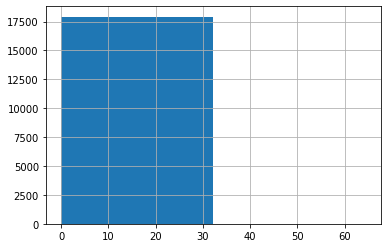

In [120]:
import matplotlib
#matplotlib.pyplot.scatter(engt_df['engagement_score'])

engt_df['engagement_score'].hist(bins=2)

### Logistic Regression

In [134]:
q3=np.percentile(engt_df['engagement_score'], 75)
top_quartile=engt_df[engt_df['engagement_score']>q3]
top_quartile['username'].unique()

array(['@tim_cook', '@elonmusk', '@anandmahindra', '@benioff',
       '@boeingceo', '@eldsjal', '@johnlegere', '@sundarpichai', '@levie',
       '@lloydblankfein', '@michaeldell', '@satyanadella',
       '@waltbettinger', '@marissamayer', '@jack', '@aneelb', '@mtbarra',
       '@drewhouston', '@indranooyi', '@westernunionceo', '@chuckrobbins',
       '@jeffbezos', '@lisasu'], dtype=object)

### Top Quartile engagement score

In [135]:
y_eng_top= engt_df['engagement_score']
X_eng_top=engt_df[['glasdoor_ceo_approval',  'sentiment_score', 'work', 'business', 'emotion', 'social', 'technology',
 'general', 'personal', 'product', 'politics', 
 'apple', 'tesla', 'mahindra', 'boeing', 'spotify', 'tmobile', 'google', 'box',
 'goldman', 'dell',  'news_corp',  'microsoft', 'schwabs',  'yahoo',
 'okta', 'twitter', 'workday', 'general1_motors',
 'dropbox', 'pepsico', 'westernunion', 'cisco', 'amazon', 'amd']]

In [136]:
#Engagement model-top quartile
eng_model_top = sm.OLS(y_eng_top, X_eng_top).fit()
eng_model_top.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       engagement_score   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     28.93
Date:                Tue, 03 Dec 2019   Prob (F-statistic):          2.75e-179
Time:                        19:32:14   Log-Likelihood:                -35606.
No. Observations:               17933   AIC:                         7.128e+04
Df Residuals:                   17898   BIC:                         7.155e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
glasdoor_ceo_approval     0.1908      0.042      4.572      0.000       0.109       0.273
sentiment_score          -0.1143      0.046     -2.468      0.014      -0.205      -0.024
work                     -0.0558      0.045     -1.253      0.210      -0.143       0.031
business                 -0.0954      0.038     -2.536      0.011      -0.169      -0.022
emotion                   0.0376      0.042      0.896      0.370      -0.045       0.120
social                    0.0717      0.043      1.669      0.095      -0.013       0.156
technology               -0.2249      0.055     -4.089      0.000      -0.333      -0.117
general                  -0.1202      0.087     -1.386      0.166      -0.290       0.050
personal                  0.1933      0.073      2.665      0.008       0.051       0.335
product                  -0.0852      0.052     -1.640      0.101      -0.187       0.017
politics                  0.7711      0.127      6.054      0.000       0.521       1.021
apple                     0.5649      0.093      6.045      0.000       0.382       0.748
tesla                     1.1401      0.053     21.323      0.000       1.035       1.245
mahindra                  0.0317      0.053      0.602      0.547      -0.072       0.135
boeing                   -0.0466      0.094     -0.495      0.621      -0.231       0.138
spotify                  -0.1116      0.122     -0.913      0.361      -0.351       0.128
tmobile                  -0.1415      0.053     -2.662      0.008      -0.246      -0.037
google                    0.1168      0.099      1.180      0.238      -0.077       0.311
box                       0.1472      0.092      1.606      0.108      -0.032       0.327
goldman                   0.1081      0.225      0.480      0.631      -0.333       0.549
dell                     -0.0682      0.071     -0.955      0.339      -0.208       0.072
news_corp                -0.0900      1.764     -0.051      0.959      -3.548       3.368
microsoft                -0.0005      0.090     -0.005      0.996      -0.177       0.176
schwabs                  -0.1043      0.094     -1.112      0.266      -0.288       0.080
yahoo                     0.2047      0.225      0.911      0.363      -0.236       0.645
okta                     -0.1222      0.167     -0.731      0.465      -0.450       0.205
twitter                   0.1261      0.048      2.611      0.009       0.031       0.221
workday                  -0.0146      0.192     -0.076      0.939      -0.390       0.361
general1_motors          -0.0254      0.130     -0.195      0.845      -0.281       0.230
dropbox                  -0.0823      0.309     -0.266      0.790      -0.688       0.523
pepsico                  -0.1338      0.178     -0.753      0.452      -0.482       0.215
westernunion           

#### Logistic Regression

In [166]:
#Binning :
engagement_median = engt_df['engagement_score'].median()
engt_df["engagement"] = engt_df['engagement_score'].apply(lambda x: 1 if x > engagement_median else 0)

C:\Users\aishw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [170]:

#clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_eng_top,engt_df["engagement"] ) 

logit1 = sm.Logit(engt_df["engagement"], X_eng_top)
result = logit.fit()
result.summary()

         Current function value: 0.467272
         Iterations: 35


C:\Users\aishw\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             engagement   No. Observations:                17933
Model:                          Logit   Df Residuals:                    17898
Method:                           MLE   Df Model:                           34
Date:                Tue, 03 Dec 2019   Pseudo R-squ.:                  0.3259
Time:                        20:08:53   Log-Likelihood:                -8379.6
converged:                      False   LL-Null:                       -12430.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
glasdoor_ceo_approval    -0.9768      0.054    -18.254      0.000      -1.082      -0.872
sentiment_score          -0.1265      0.066     -1.915      0.055      -0.256       0.003
work                      0.1024      0.062      1.663      0.096      -0.018       0.223
business                 -0.0061      0.052     -0.116      0.908      -0.109       0.097
emotion                   0.1464      0.059      2.480      0.013       0.031       0.262
social                    0.2087      0.060      3.490      0.000       0.091       0.326
technology                0.2388      0.082      2.927      0.003       0.079       0.399
general                  -0.2225      0.121     -1.844      0.065      -0.459       0.014
personal                  0.4039      0.100      4.049      0.000       0.208       0.599
product                   0.1752      0.078      2.232      0.026       0.021       0.329
politics                 -0.1969      0.168     -1.175      0.240      -0.525       0.132
apple                     6.8001      1.002      6.785      0.000       4.836       8.764
tesla                    22.7127   1145.983      0.020      0.984   -2223.372    2268.797
mahindra                  1.9033      0.067     28.444      0.000       1.772       2.034
boeing                   -0.2482      0.119     -2.090      0.037      -0.481      -0.015
spotify                  -1.0508      0.198     -5.300      0.000      -1.439      -0.662
tmobile                  -0.4512      0.071     -6.348      0.000      -0.591      -0.312
google                    2.7721      0.164     16.870      0.000       2.450       3.094
box                       1.5429      0.113     13.699      0.000       1.322       1.764
goldman                   4.9658      1.009      4.920      0.000       2.988       6.944
dell                      0.5663      0.084      6.726      0.000       0.401       0.731
news_corp                -7.7098     60.011     -0.128      0.898    -125.329     109.909
microsoft                 2.4264      0.133     18.264      0.000       2.166       2.687
schwabs                  -4.1394      0.581     -7.122      0.000      -5.279      -3.000
yahoo                     0.2048      0.264      0.775      0.438      -0.313       0.723
okta                     -3.9125      1.005     -3.891      0.000      -5.883      -1.942
twitter                   0.6611      0.058     11.411      0.000       0.548       0.775
workday                  -0.4517      0.264     -1.712      0.087      -0.969       0.065
general1_motors           0.0275      0.153      0.180      0.857      -0.273       0.328
dropbox                  -0.0585      0.383     -0.153      0.879      -0.809       0.692
pepsico                   0.2217      0.209      1.061      0.289      -0.188       0.631
westernunion             -1.8531      0.137    -13.576      0.000      -2.121      -1.586
cisco                     0.0405      0.089      0.455      0.649      -0.134       0.215
a